# XGBoost model 
In this notebook we create and tune a XGBoost model. We tune the model using stratified cross-validation in order to keep constant the target variable distribution among different folds. <br>
In the end we show the performance of our model using a stratified random hold out (80%-20%) and then we test it also using the SITE_ID hold out (the one used for the final test set). <br>
We can notice a big difference of performances between the random hold out test and the SITE_ID split test

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from numpy import argmax


import warnings
import sys
warnings.filterwarnings('ignore')
sys.path.append('..')

In [ ]:
from helper import data_container

## Support functions for plots

In [2]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

def plot_roc_curve(y, predictions, ax):
    fpr, tpr, thresholds = roc_curve(y, predictions)
    ax.plot([0,1], [0,1], linestyle='--', label='xgboost')
    ax.plot(fpr, tpr, marker='.', label='Logistic')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    ax.plot()

def plot_precision_recall_curve(y, predictions, ax):
    precision, recall, thresholds = precision_recall_curve(y, predictions)
    no_skill = len(y[y==1]) / len(y)
    ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    ax.plot(recall, precision, marker='.', label='xgboost')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.legend()
    ax.plot()

    
rectifier = lambda x, thr: 0 if x < thr else 1

## Model parameters

In [3]:
MAX_TREE_DEPTH = 8
TREE_METHOD = 'gpu_hist' ##train on gpu is considerably faster 
ITERATIONS = 1000 #num_boost_round
SUBSAMPLE = 0.6
REGULARIZATION = 0.1
GAMMA = 0.3
POS_WEIGHT = 200
EARLY_STOP = 10



## Dataset preparation

In [4]:

container = data_container(pd.read_csv('../dataset/train.csv'), drop=False)


In [5]:
train_df = container.prepared_dataset
train_df_14d = container.compute_14d_features()
train_df = train_df_14d

next_col=[col for col in train_df.columns if 'next' in col and not 'aircon' in col]
aircon_sum_prev = ['aircon_sum_wo_prev14d', 'mean_temperature_prev14d']

to_drop = next_col + aircon_sum_prev + ['ge_min_persistance_prev14d', 'ge_mean_persistance_prev14d'] +['year']

train_df = train_df.drop(columns=to_drop)


train_model = train_df.copy()
X = train_df.drop(columns=['DATE', 'SITE_ID', 'aircon_sum_target_next14d'])
y = train_df['aircon_sum_target_next14d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


train_df = X_train.copy()
train_df['target'] = y_train


# Model training
We will start by evaluating xgboost performances on a 5-fold validation with 80/20 train/test split

In [6]:
params = {'tree_method': 'gpu_hist',
          'max_depth': MAX_TREE_DEPTH,
          'alpha': REGULARIZATION,
          'gamma': GAMMA,
          'subsample': SUBSAMPLE,
          'scale_pos_weight': POS_WEIGHT,
          'learning_rate': 0.1, 
          'verbosity': 3, 
          'objective':'binary:logistic',
          'eval_metric': 'aucpr',
          'predictor' : 'gpu_predictor',
          }

In [7]:
nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train_df))

target = 'target'
predictors = train_df.drop(columns='target').columns


i = 1
models = []

for train_index, valid_index in skf.split(train_df, train_df.target.values):
    print("\nFold {}".format(i))
    xg_train = xgb.DMatrix(train_df.iloc[train_index][predictors].values,
                           train_df.iloc[train_index][target].values,                           
                           )
    xg_valid = xgb.DMatrix(train_df.iloc[valid_index][predictors].values,
                           train_df.iloc[valid_index][target].values,                           
                           )   

    
    clf = xgb.train(params, xg_train, 500, evals=[(xg_train, "train"), (xg_valid, "eval")],
                early_stopping_rounds=300, verbose_eval=4)
    oof[valid_index] = clf.predict(xgb.DMatrix(train_df.iloc[valid_index][predictors].values))
    models.append(clf)
    i = i+1


Fold 1
[20:47:58] DEBUG: ../src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[20:47:59] DEBUG: ../src/common/device_helpers.cu:38: Running nccl init on: 10.0
[20:47:59] ======== Monitor: SketchContainer ========
[20:47:59] MakeCuts: 0.000653s, 1 calls @ 653us

[20:47:59] Prune: 0.000347s, 1 calls @ 347us

[20:47:59] Push: 1e-05s, 1 calls @ 10us

[20:47:59] Unique: 0.000395s, 2 calls @ 395us

[20:47:59] ======== Monitor: DenseCuts ========
[20:47:59] ======== Monitor: HistogramCuts ========
[0]	train-aucpr:0.06871	eval-aucpr:0.05429
Multiple eval metrics have been passed: 'eval-aucpr' will be used for early stopping.

Will train until eval-aucpr hasn't improved in 300 rounds.
[4]	train-aucpr:0.12466	eval-aucpr:0.09734
[8]	train-aucpr:0.16311	eval-aucpr:0.13251
[12]	train-aucpr:0.20935	eval-aucpr:0.15612
[16]	train-aucpr:0.25512	eval-aucpr:0.18580
[20]	train-aucpr:0.28310	eval-aucpr:0.20382
[24]	train-aucpr:0.34340	eval-aucpr:0.25250
[28]	train-aucpr:0.41276	eval-aucpr:0.29679
[3

# Prediction

In [8]:
test_predictions = np.zeros(len(X_test))
for mdl in models:
    test_predictions += mdl.predict(xgb.DMatrix(X_test[predictors].values))/nfold
    


Plotting the results

f1 score:  0.8438162544169611
precision:  0.8257261410788381
recall: 0.8627167630057804
auc precision-recall:  0.8915817435465575


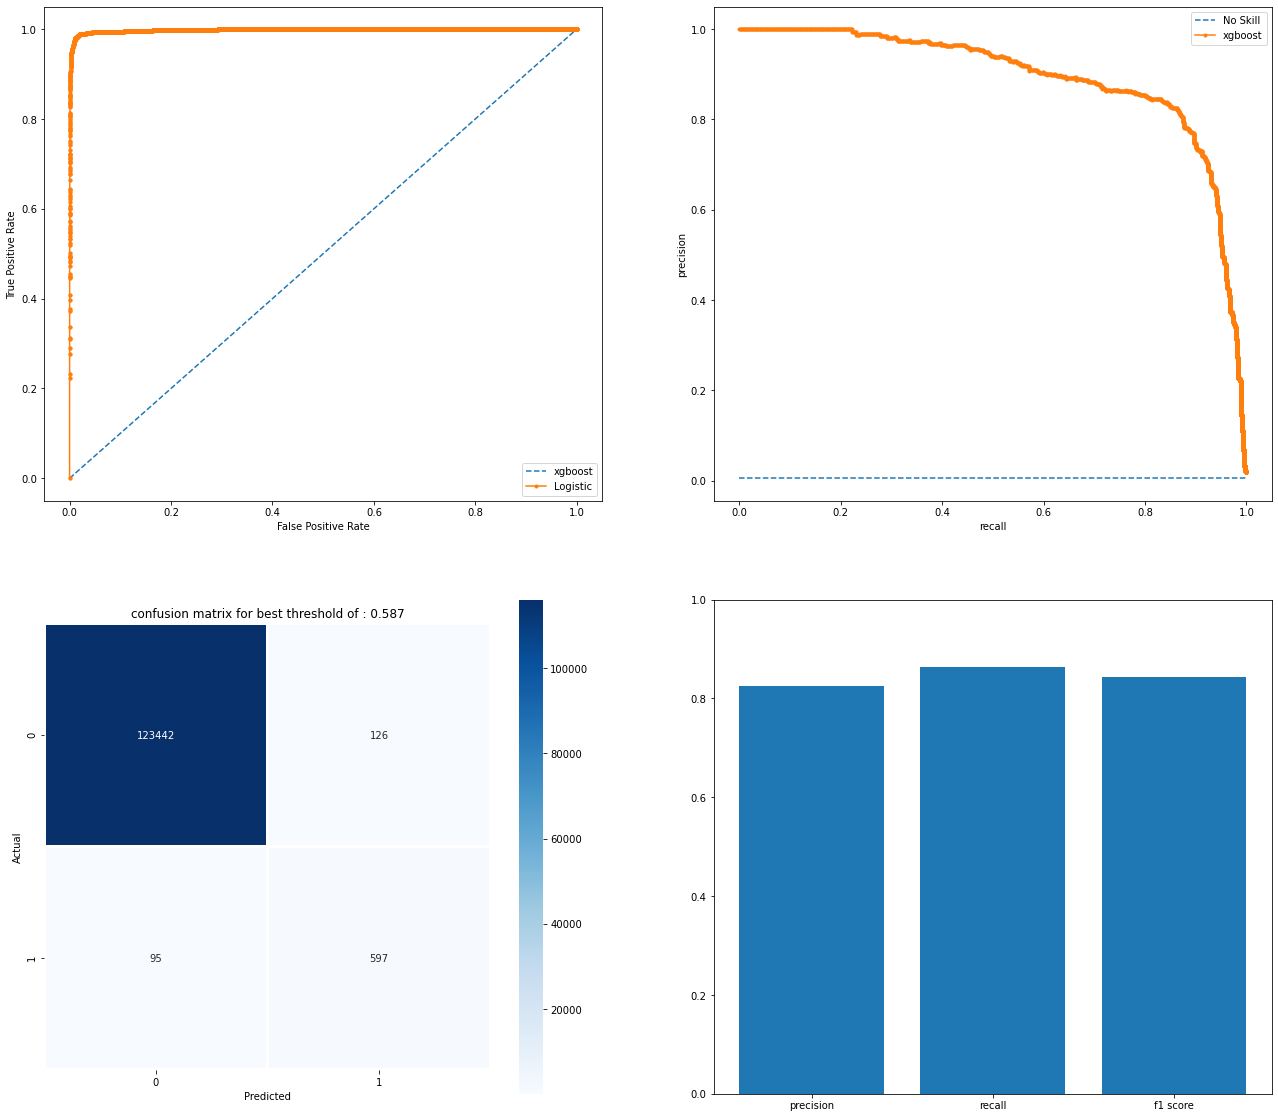

In [9]:
from matplotlib import pyplot as plt

f, axs = f, axs = plt.subplots(figsize= (22,20), ncols=2, nrows=2)
plot_roc_curve(y_test, test_predictions, axs[0][0])
precision, recall, thresholds = precision_recall_curve(y_test, test_predictions)
plot_precision_recall_curve(y_test, test_predictions, axs[0][1])


fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
max_fscore = fscore[ix]
best_thr = thresholds[ix]
rectified = np.array([rectifier(x, best_thr) for x in test_predictions])


confusion_matrix = pd.crosstab(y_test.values, rectified, rownames=['Actual'], colnames=['Predicted'])
heatmap_title = 'confusion matrix for best threshold of : {thr:.3f}'
sns.heatmap(confusion_matrix, annot=True, fmt='d', square=True, cmap='Blues',
            ax=axs[1][0], robust=True, linewidth=2).set(title=heatmap_title.format(thr = best_thr));


max_precision = precision[ix]
max_recall = recall[ix]

x_bar = np.arange(3)
y_bar = np.array([max_precision, max_recall, max_fscore])
axs[1,1].set_ylim(0, 1)
axs[1,1].bar(x_bar, y_bar)
axs[1,1].set_xticks([0, 1, 2])
axs[1,1].set_xticklabels(['precision', 'recall', 'f1 score']);


print('f1 score: ', max_fscore)
print('precision: ', max_precision)
print('recall:', max_recall)
print('auc precision-recall: ', auc(recall, precision))

# Plotting features importance

In [10]:
frames = []
for mdl in models:
    frames.append(pd.DataFrame.from_dict(mdl.get_fscore(), orient='index').T)

df2 = pd.concat(frames).reset_index(drop=True)

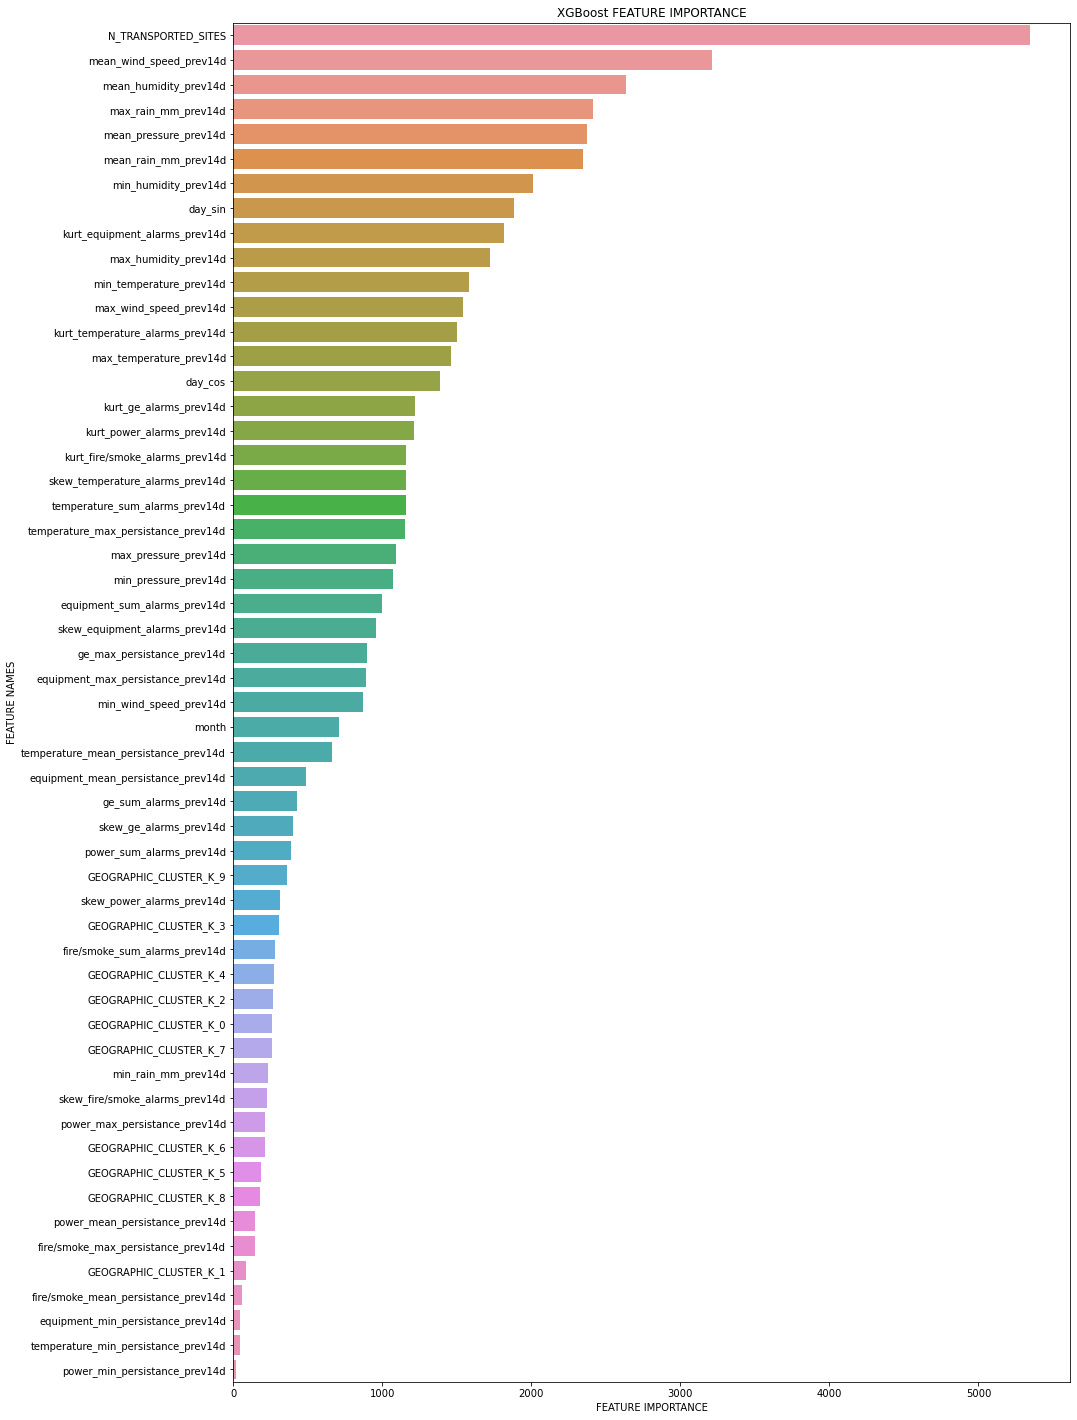

In [11]:
mean_important_features = df2.mean(axis=0)

cols = train_df.columns
col_map = {}
i = 0
for col in cols:
    col_map[col] = 'f'+ str(i)
    i = i + 1
cols_to_add = []
importances = []
for k,v in col_map.items():
    if v in mean_important_features.index:
        importances.append(mean_important_features.at[v])
        cols_to_add.append(k)


plot_feature_importance(importances,cols_to_add, 'XGBoost ')

We noticed one important thing, the model obtain good performances without splitting the set based on the **SITE_ID**. Interesting enough this consideration brought us to consider the case in which train and test are splitted on the **SITE_ID**.

# Training on "SITE_ID" split to asses the performances
We emulate the same split "criteria" of the available test set in order to assess the final performances of our model.

In [12]:
np.random.seed(seed=1234)

SITE_ID  = train_model['SITE_ID'].unique()

np.random.shuffle(SITE_ID)

oldout_ID = [x for x in SITE_ID if np.random.uniform(0, 1) < 0.2]


In [13]:
oldout_set =  train_model[train_model['SITE_ID'].isin(oldout_ID)]
print(len(oldout_set['SITE_ID'].unique()))

train_df = train_model[~train_model['SITE_ID'].isin(oldout_ID)]
print(len(train_model['SITE_ID'].unique()))

435
2071


In [14]:
params = {'tree_method': 'gpu_hist',
          'max_depth': 8,
          'alpha': REGULARIZATION,
          'gamma': 0.5,
          'subsample': SUBSAMPLE,
          'scale_pos_weight': 200,
          'learning_rate': 0.2, 
          'verbosity': 3, 
          'objective':'binary:logistic',
          'eval_metric': 'logloss',
          'predictor' : 'gpu_predictor',
          'n_estimators' : 200
          }



model = xgb.XGBClassifier(**params)


In [15]:

y_train = train_df['aircon_sum_target_next14d']
X_train = train_df.drop(columns=['SITE_ID', 'DATE', 'aircon_sum_target_next14d'])
y_test = oldout_set['aircon_sum_target_next14d']
X_test = oldout_set.drop(columns=['aircon_sum_target_next14d', 'DATE', 'SITE_ID'])

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(490800, 56)
(490800,)
(130500, 56)
(130500,)


In [17]:
model.fit(X_train, y_train, eval_metric='aucpr',eval_set=[(X_test, y_test)], early_stopping_rounds= 200)
test_predictions = model.predict_proba(X_test)[:, 1]

[20:51:22] DEBUG: ../src/tree/updater_gpu_hist.cu:827: [GPU Hist]: Configure
[20:51:22] DEBUG: ../src/common/device_helpers.cu:38: Running nccl init on: 10.0
[20:51:22] ======== Monitor: SketchContainer ========
[20:51:22] MakeCuts: 0.000652s, 1 calls @ 652us

[20:51:22] Prune: 0.000348s, 1 calls @ 348us

[20:51:22] Push: 1.8e-05s, 1 calls @ 18us

[20:51:22] Unique: 0.000371s, 2 calls @ 371us

[20:51:22] ======== Monitor: DenseCuts ========
[20:51:22] ======== Monitor: HistogramCuts ========
[0]	validation_0-aucpr:0.01735
Will train until validation_0-aucpr hasn't improved in 200 rounds.
[1]	validation_0-aucpr:0.02858
[2]	validation_0-aucpr:0.03806
[3]	validation_0-aucpr:0.04451
[4]	validation_0-aucpr:0.02128
[5]	validation_0-aucpr:0.02251
[6]	validation_0-aucpr:0.02351
[7]	validation_0-aucpr:0.02320
[8]	validation_0-aucpr:0.02117
[9]	validation_0-aucpr:0.02312
[10]	validation_0-aucpr:0.02352
[11]	validation_0-aucpr:0.02883
[12]	validation_0-aucpr:0.03332
[13]	validation_0-aucpr:0.0321

f1 score:  0.15742793791574278
precision:  0.29831932773109243
recall: 0.10692771084337349
auc precision-recall:  0.03498088472880891


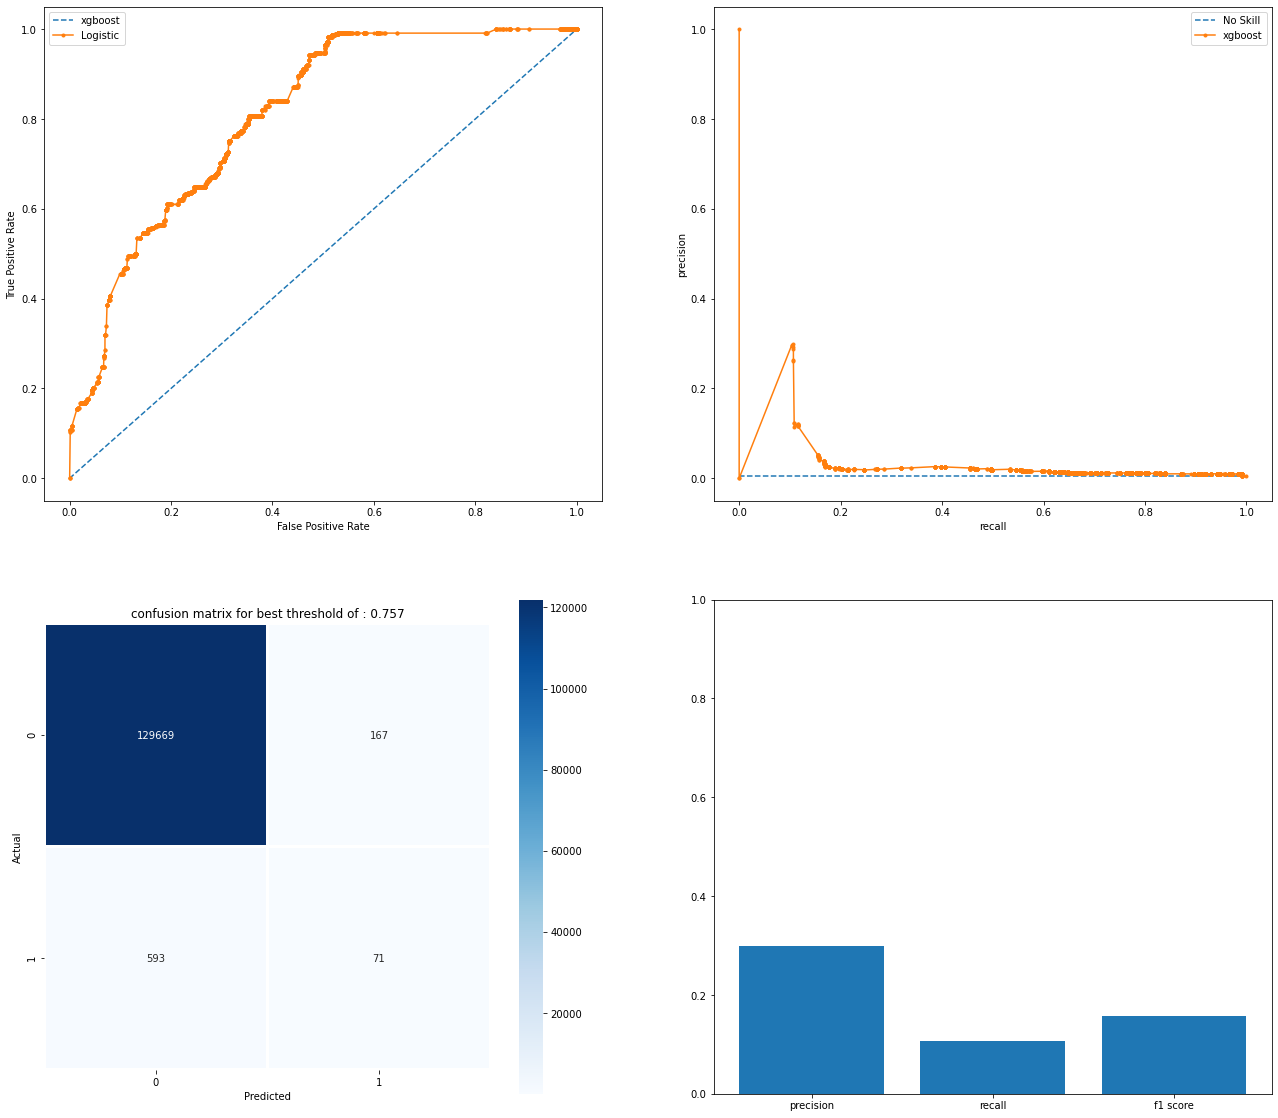

In [18]:
from matplotlib import pyplot as plt

f, axs = f, axs = plt.subplots(figsize= (22,20), ncols=2, nrows=2)
plot_roc_curve(y_test, test_predictions, axs[0][0])
precision, recall, thresholds = precision_recall_curve(y_test, test_predictions)
plot_precision_recall_curve(y_test, test_predictions, axs[0][1])


fscore = (2 * precision * recall) / (precision + recall)
fscore = fscore[~np.isnan(fscore)]
ix = argmax(fscore)
max_fscore = fscore[ix]
best_thr = thresholds[ix]
rectified = np.array([rectifier(x, best_thr) for x in test_predictions])


confusion_matrix = pd.crosstab(y_test.values, rectified, rownames=['Actual'], colnames=['Predicted'])
heatmap_title = 'confusion matrix for best threshold of : {thr:.3f}'
sns.heatmap(confusion_matrix, annot=True, fmt='d', square=True, cmap='Blues',
            ax=axs[1][0], robust=True, linewidth=2).set(title=heatmap_title.format(thr = best_thr));


max_precision = precision[ix]
max_recall = recall[ix]

x_bar = np.arange(3)
y_bar = np.array([max_precision, max_recall, max_fscore])
axs[1,1].set_ylim(0, 1)
axs[1,1].bar(x_bar, y_bar)
axs[1,1].set_xticks([0, 1, 2])
axs[1,1].set_xticklabels(['precision', 'recall', 'f1 score']);


print('f1 score: ', max_fscore)
print('precision: ', max_precision)
print('recall:', max_recall)
print('auc precision-recall: ', auc(recall, precision))

### Splitting on SITE_ID give bad results. The algorithms doesn't seem to be able to predict unseen sites faults from the data of other sites.

# Parameter Tuning, Cross validation
We run gridsearch to find the best parameters, indeed xgboost is infamous for the large numbers of parameters that can have a big impact on performances

In [19]:
# parameters grid
LEARNING_RATES = [0.4]
GAMMAS = [0, 2, 3]
MAX_DEPTHS = [6, 8, 10]
COLSAMPLES = [0.8, 1.0]
SUBSAMPLES = [0.4, 0.6]
REG_ALPHAS = [0, 0.1, 0.5, 1]
REG_LAMBDAS = [0 , 1]
MIN_CHILD_WEIGHT =  [1, 2]
N_ESTIMATORS = [10,50, 500, 1000, 1500, 2000]

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [21]:


fixed_params = {'tree_method': 'auto',
                'verbosity': 2,
                'objective':'binary:logistic',
                'eval_metric': ['auc','logloss'],
                'subsample' : 0.6,
                'min_child_weight' : 1,
                "colsample_bytree": 0.8,
                'learning_rate': 0.4, 
                'alpha': 1,
                'gamma' : 0,
                'early_stopping_rounds' : 20
                }


params_grid_search = {
                  'max_depth': MAX_DEPTHS,
                  'n_estimators': N_ESTIMATORS,
                }





model = xgb.XGBClassifier(**fixed_params)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
random_search_cv = RandomizedSearchCV(model, params_grid_search, cv=skf, scoring='f1', verbose=3, n_iter=1000)

[20:51:34] ======== Monitor: Learner ========
[20:51:34] Configure: 0.002479s, 1 calls @ 2479us

[20:51:34] ======== Monitor: GBTree ========
[20:51:34] ======== Device 0 Memory Allocations:  ========
[20:51:34] Peak memory usage: 522MiB
[20:51:34] Number of allocations: 1398921
[20:51:34] ======== Monitor: updater_gpu_hist ========
[20:51:34] ======== NCCL Statistics========
[20:51:34] AllReduce calls: 0
[20:51:34] AllReduce total MiB communicated: 0
